# Environmental analysis: weather influence on phosphorus in swiss lakes

## Introduction
This report present the results qnd interpretation of the analysis of environmental data about phosphorus concentration in lakes in Switzerland, as well as weather data (insolation, rainfall, temperature, fresh snow) in several locations in the country. This work aim to identify tendancies and changes over time. But the main objective is to show if there is any potential correlations between the concentration of phosphorus and climate in swiss lakes.

## Material and methods
### Datasets
This work is based on two datasets available on [opendata.swiss](https://opendata.swiss):
- [Klimadaten: Sonnenscheindauer, Niederschlag, Temperatur und Neuschnee](https://opendata.swiss/en/dataset/klimadaten-sonnenscheindauer-niederschlag-temperatur-und-neuschnee4) (Climate data: insolation time, precipitation, temperature and fresh snowfall)
- [Phosphorgehalt in Seen](https://opendata.swiss/en/dataset/phosphorgehalt-in-seen5) (Phosphorus content in lakes).
The climate dataset consist in four sheets (insolation time in h per year, precipitation in cumulative mm per year, temperature in mean °C per year, and fresh snowfall in cumulative cm per year) of data for 13 locations (Basel-Binningen, Bern- Zollikofen, Davos, Geneva-Cointrin, Locarno-Monti, Lugano, Lucerne, Neuchâtel, Säntis, Sion, St-Gallen and Zurich-Fluntern) from 1931 to 2024. The phosphorus dataset consist in a table of the annual measurements of phosphorus concentration in µg/l in six lakes (lake Lucerne, lake Hallwil, lake Neuchâtel, lake Constance, lake Zug and lake Geneva) from 1951 (first data from 1957) to 2023.

### Methods
#### Cleaning and importing the data
First, the datasets have been cleaned in LibreOffice Calc. Next to making the files more easily usable with Python, the cleaning was also usefull to get rid of all irrelevant data. This particularly concerns the locations in the climate dataset.

The phosphorus dataset covers six lakes, whereas the climate dataset covers 13 locations, most of which being quite remote from the said lakes. So, in order to get the most accurate climate data for the lakes, only the locations closest to the lakes were retained in the climate dataset. For Lake Lucerne, Lake Neuchâtel and Lake Geneva, the locations retained were quite obviously Lucerne, Neuchâtel and Geneva-Cointrin, since they are next to the lakes. For the Lake Constance and Lake Zug, St-Gallen and Lucerne respectively were retained since they are the closest location in proximity and altitude. Concerning Lake Hallwil, both Lucerne and Zurich-Fluntern are the best candidates in terms of proximity and altitude. However, Lucerne was chosen since the city is a bit smaller than Zurich, slighlty reducing the influence of urbanism. In addition, there are several peaks between the lake and Zurich, whereas the space between the lake and Lucerne is a bit flatter, potentially resulting in a bigger climatic difference between the lake and Zurich than between the lake and Lucerne. Zurich-Fluntern was nevertheless kept in the dataset, for comparison purposes.

After the cleaning, the spreadsheet files were imported using the pandas package.

In [1]:
# Importing required package
import pandas as pd

# Importing the datasets
phosphorus = pd.read_excel("phosphorus-lakes.xlsx", na_values=["..."])
insolation = pd.read_excel("weather-data.xlsx", sheet_name="Insolation", na_values=["..."])
rainfall = pd.read_excel("weather-data.xlsx", sheet_name="Rainfall", na_values=["..."])
temperature = pd.read_excel("weather-data.xlsx", sheet_name="Temperature", na_values=["..."])
snow = pd.read_excel("weather-data.xlsx", sheet_name="Fresh snow", na_values=["..."])

#### Exploratory analysis
Before looking for possible correlations, some basic analyses were performed. First, the descriptive statistics of each dataset were calculated. Then, these datasets were analyzed to identify linear trends, and the data were plotted in scatter plots, so that the trends could be visualized. Finally, the descriptive statistics, trend analysis results, and trend comparisons between the variables were stored in a JSON file, for easier access.

Note: all the files and figures produced by the analyses are also present as individual files in the corresponding directories ("Exploratory analysis outputs" and "Regression models outputs"); figures are named in order of appearences in this notebook.

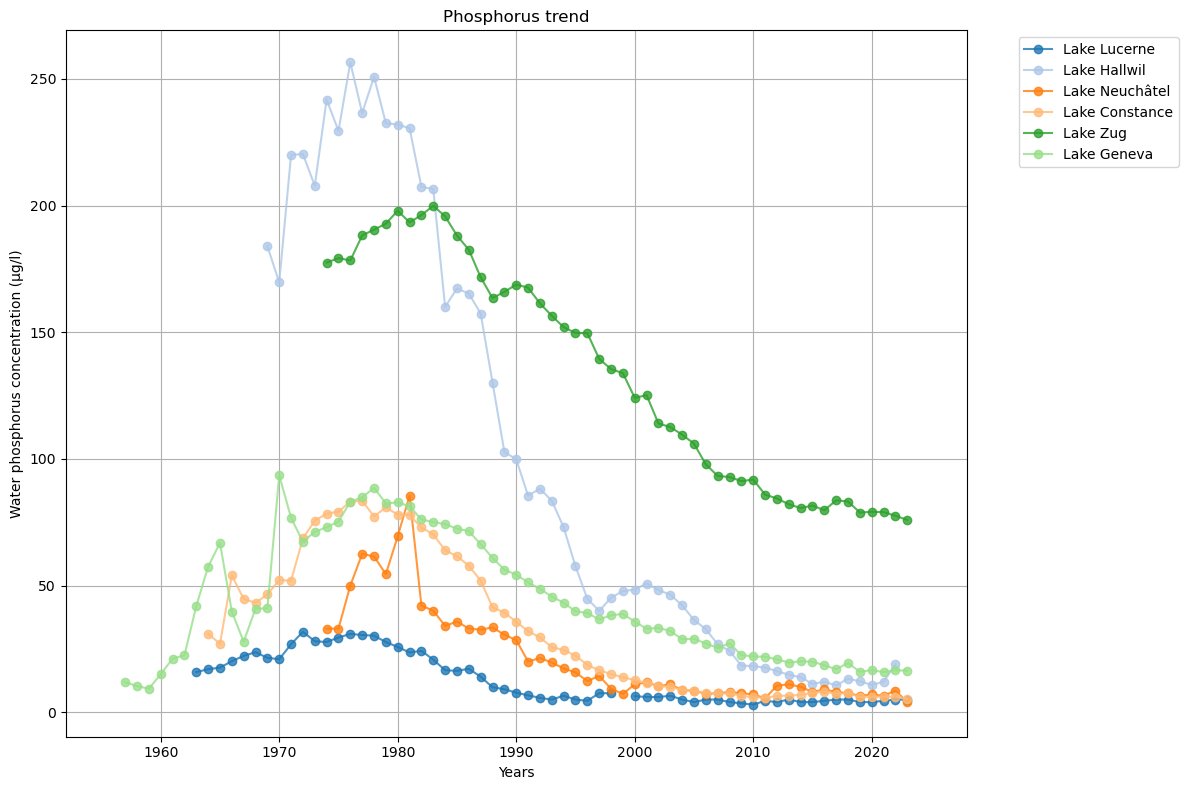

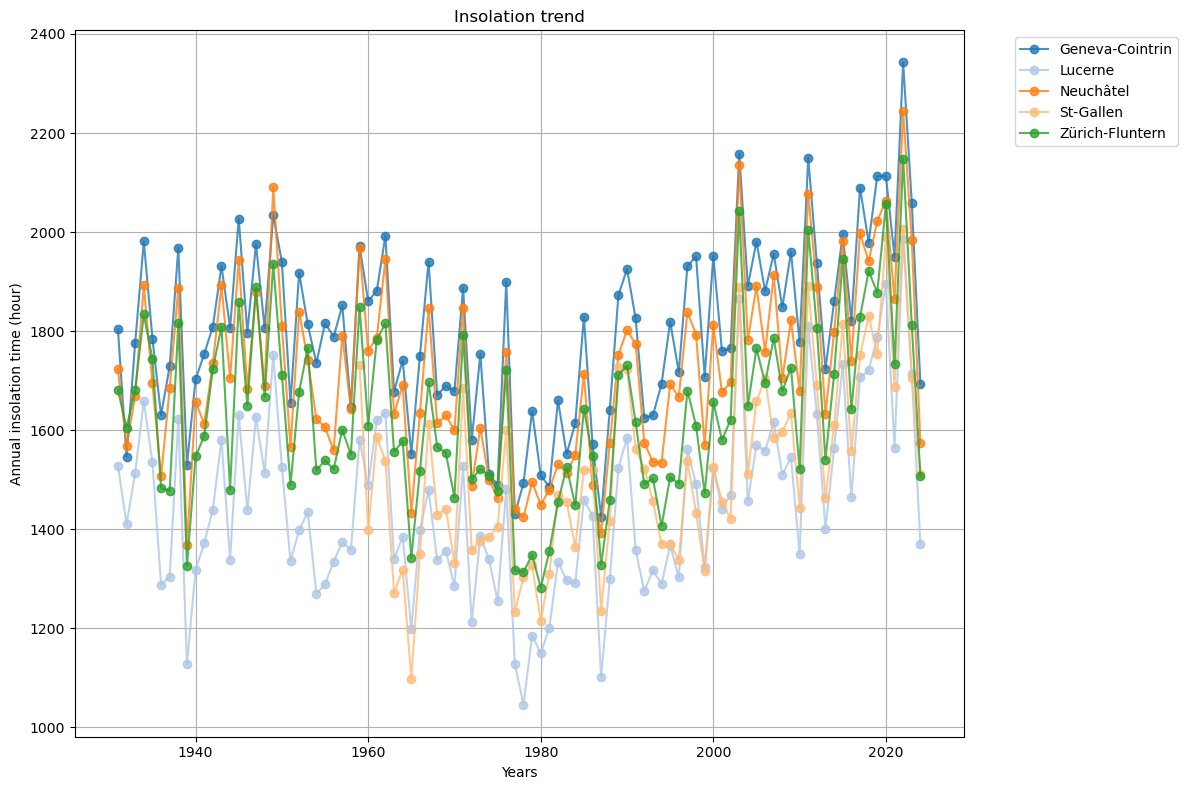

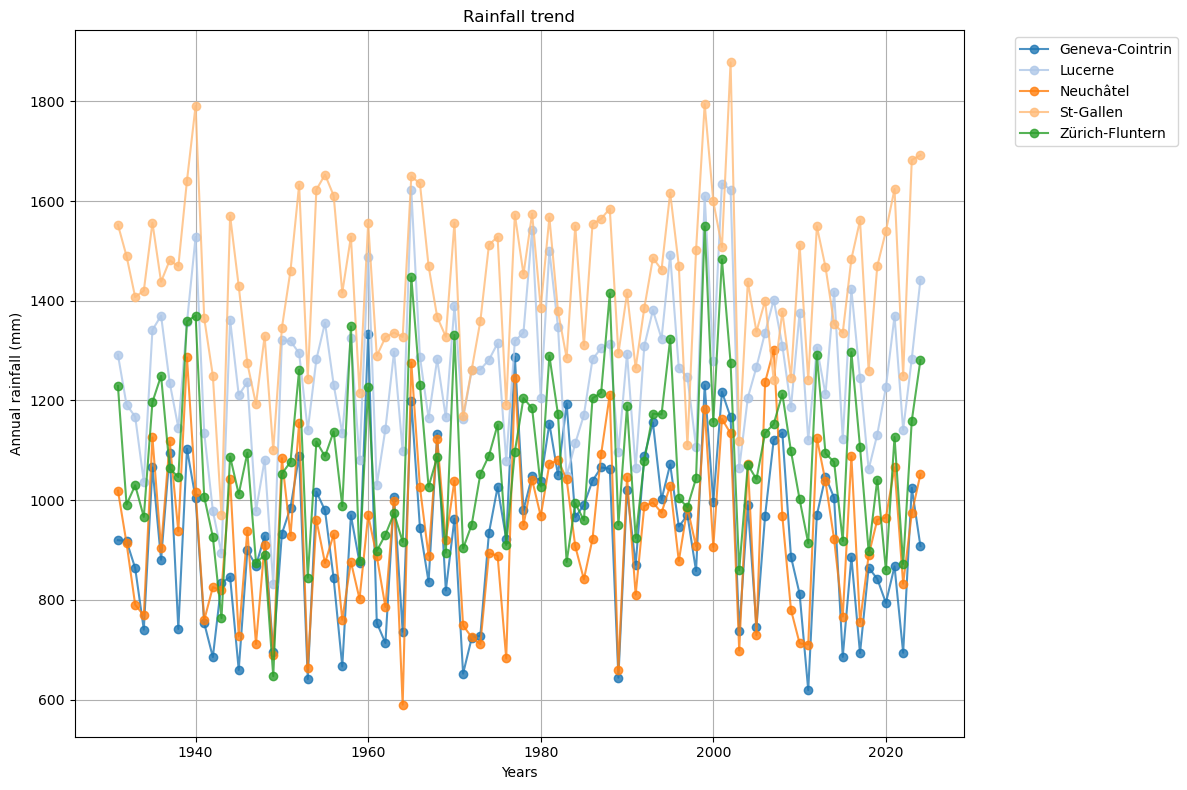

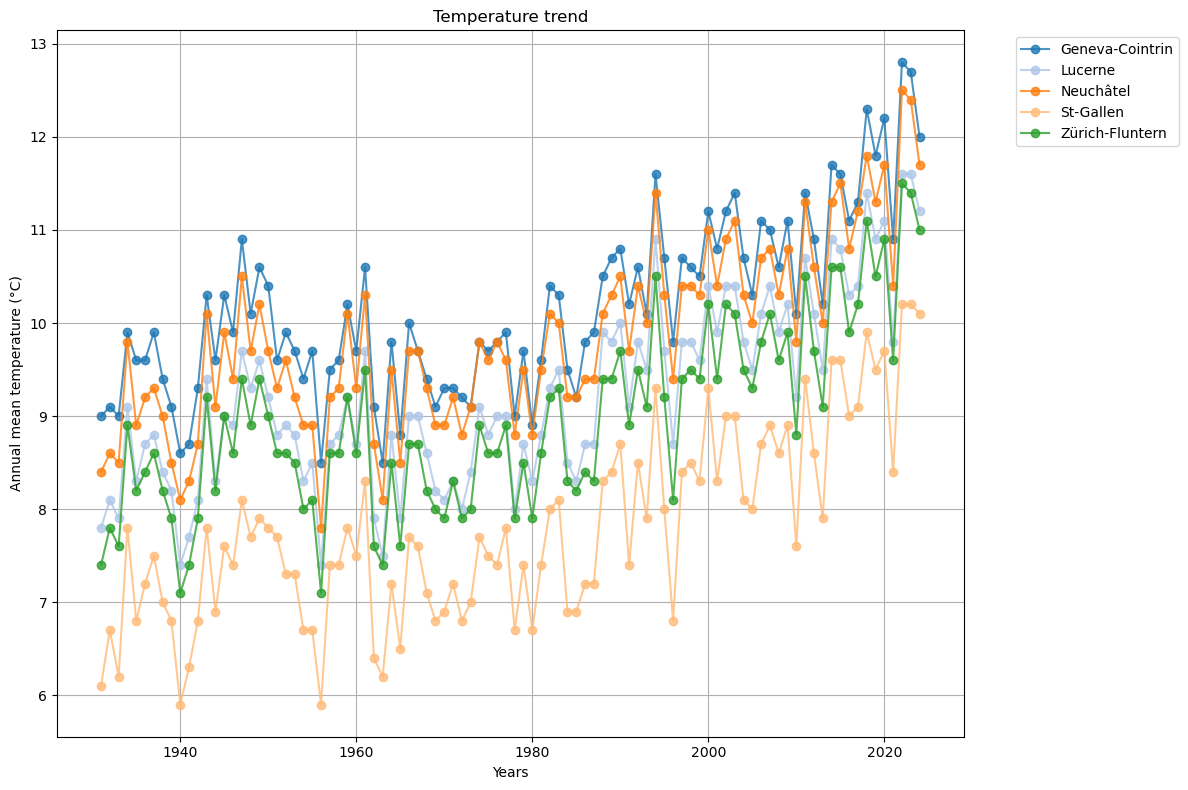

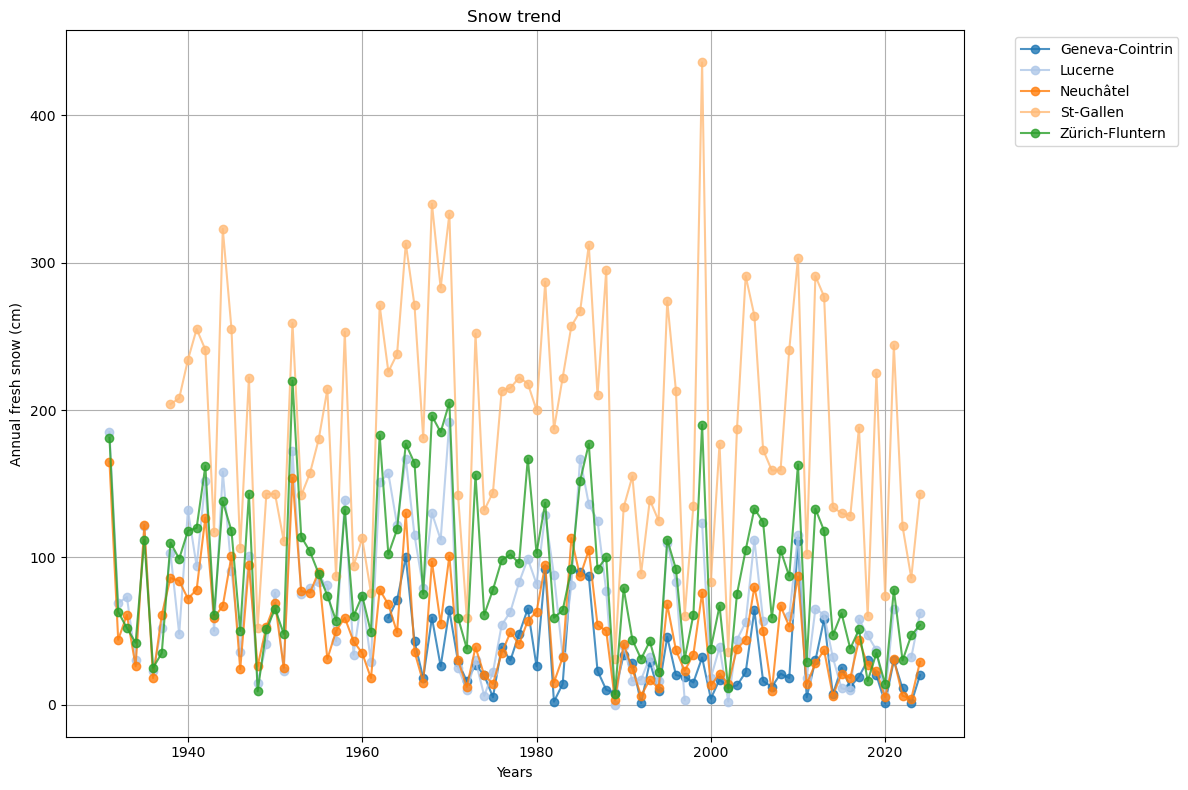

Trends analysis completed. The results are saved in 'trends_results.json'.


In [2]:
# Importing required packages
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import json

# Function to generate descriptive statistics
def desc_stat(df, x_col, y_col):
    stats = df[[x_col, y_col]].iloc[:, 1:].describe().to_dict()
    return stats

# Function for analysing linear trends
def detect_trends(df, x_col, y_col):
    # Removing NaN values for both columns
    valid_data = df[[x_col, y_col]].dropna()
    
    # Making sure there is enough values for the analysis
    if len(valid_data) > 1:
        x = valid_data[x_col].astype(float)
        y = valid_data[y_col].astype(float)
        regression = linregress(x, y)
        trend = "positive" if regression.slope > 0 else "negative"
        return {"slope": regression.slope, "intercept": regression.intercept, "r_value": regression.rvalue, "trend": trend}
    else:
        return None

# Function for plotting graphs
def plot_graph(dataframes, x_col, y_cols, title, xlab, xlim_inf, xlim_sup, ylab):
    plt.figure(figsize=(12, 8))

    cmap = plt.get_cmap("tab20") # Use color map with 20 different colors
    num_colors = cmap.N # Get the number of colors in the color map

    for i, (df, y_col, label) in enumerate(dataframes):
        color = cmap(i % num_colors) # Cycle through the color map
        plt.plot(df[x_col], df[y_col], marker = "o", linestyle = "-", label = label, color = color, alpha = 0.8)
    
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)
    plt.xlim(xlim_inf,xlim_sup)
    plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left") # Avoid overlapping with the graph
    plt.tight_layout()
    plt.show()

# Function for comparing trends
def compare_trends(trend1, trend2):
    if trend1["trend"] == trend2["trend"]:
        return "Trends are similar."
    else:
        return "Trends are opposite."

# Trends detection for each dataset
trends_results = {}
descriptive_stats = {}
comparisons = {}

# Phosphorus analysis
lakes = phosphorus.columns[1:]
data_to_plot = []
trends_results["Phosphorus"] = {}
descriptive_stats["Phosphorus"] = {}
for lake in lakes:
    trend = detect_trends(phosphorus, "Year", lake)
    stats = desc_stat(phosphorus, "Year", lake)
    if trend:
        trends_results["Phosphorus"][lake] = trend
        descriptive_stats["Phosphorus"][lake] = stats
        data_to_plot.append((phosphorus, lake, lake))
plot_graph(data_to_plot, "Year", lakes, "Phosphorus trend", "Years", 1952, 2028, "Water phosphorus concentration (µg/l)")

# Weather analysis
for dataset_name, dataset, y_legend in [("Insolation", insolation, "Annual insolation time (hour)"), ("Rainfall", rainfall, "Annual rainfall (mm)"), ("Temperature", temperature, "Annual mean temperature (°C)"), ("Snow", snow, "Annual fresh snow (cm)")]:
    stations = dataset.columns[1:]
    data_to_plot = []
    trends_results[dataset_name] = {}
    descriptive_stats[dataset_name] = {}

    for station in stations:
        trend = detect_trends(dataset, "Year", station)
        stats = desc_stat(dataset, "Year", station)

        if trend:
            trends_results[dataset_name][station] = trend
            descriptive_stats[dataset_name][station] = stats
            data_to_plot.append((dataset, station, station))

    plot_graph(data_to_plot, "Year", stations, f"{dataset_name} trend", "Years", 1926, 2029, y_legend)

# Comparing trends
for lake, phos_trend in trends_results["Phosphorus"].items():
    for climate_type in ["Insolation", "Rainfall", "Temperature", "Snow"]:
        for station, climate_trend in trends_results[climate_type].items():
            comparison = compare_trends(phos_trend, climate_trend)
            comparisons[f"{lake} vs {station} ({climate_type})"] = comparison

for climate_type1 in ["Insolation", "Rainfall", "Temperature", "Snow"]:
    for station1, trend1 in trends_results[climate_type1].items():
        for climate_type2 in ["Insolation", "Rainfall", "Temperature", "Snow"]:
            if climate_type1 != climate_type2:
                for station2, trend2 in trends_results[climate_type2].items():
                    comparison = compare_trends(trend1, trend2)
                    comparisons[f"{station1} ({climate_type1}) vs {station2} ({climate_type2})"] = comparison

# Saving trends results
with open("trends_results.json", "w") as f:
    json.dump({"Descriptive statistics": descriptive_stats, "Trends analysis results": trends_results, "Trends comparison": comparisons}, f, indent=4)

print("Trends analysis completed. The results are saved in 'trends_results.json'.")

#### Correlations and regression models
First, correlations between the phosphorus concentration and the climate data (insolation time, annual rainfall, mean annual temperature, annual fresh snow) were calculated. Then, regression models were applied.

The first models are simple and multilple linear regression models, as a starting point. Then, in case of multicolinearity between climate data, the Ridge correlation model was tested. At the same time, a Lasso regression model was also tested, in case non-explanatory variables could have been excluded. Finally, the Random Forest Regression model was also tested, to see if a non-linear model could work better.

In [3]:
# Requirements for the analyses

# Importing required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Dictionnary for correspondance between lakes (phosphorus) and stations (weather)
lake_to_station = {
        "Lake Lucerne": "Lucerne",
        "Lake Hallwil": "Lucerne",
        "Lake Neuchâtel": "Neuchâtel",
        "Lake Constance": "St-Gallen",
        "Lake Zug": "Lucerne",
        "Lake Geneva": "Geneva-Cointrin"
        }

# Melting the dataframes
phosphorus_melted = phosphorus.melt(id_vars="Year", var_name="Lake", value_name="Phosphorus")
insolation_melted = insolation.melt(id_vars="Year", var_name="Station", value_name="Insolation")
rainfall_melted = rainfall.melt(id_vars="Year", var_name="Station", value_name="Rainfall")
temperature_melted = temperature.melt(id_vars="Year", var_name="Station", value_name="Temperature")
snow_melted = snow.melt(id_vars="Year", var_name="Station", value_name="Snow")

# Mapping lakes to stations
phosphorus_melted["Station"] = phosphorus_melted["Lake"].map(lake_to_station)

# Merging dataframes together
merged_inso = pd.merge(phosphorus_melted, insolation_melted, on=["Year", "Station"], how="left")
merged_rain = pd.merge(phosphorus_melted, rainfall_melted, on=["Year", "Station"], how="left")
merged_temp = pd.merge(phosphorus_melted, temperature_melted, on=["Year", "Station"], how="left")
merged_snow = pd.merge(phosphorus_melted, snow_melted, on=["Year", "Station"], how="left")

weather_full = insolation_melted \
        .merge(rainfall_melted, on=["Year", "Station"], how="outer") \
        .merge(temperature_melted, on=["Year", "Station"], how="outer") \
        .merge(snow_melted, on=["Year", "Station"], how="outer")

phospho_weather = pd.merge(phosphorus_melted, weather_full, on=["Year", "Station"], how="left")



In [4]:
# Correlation beetwen phosphorus and climate data per lake
for lake in phospho_weather["Lake"].unique():
    subset = phospho_weather[phospho_weather["Lake"] == lake]
    print(f"\nCorrelation for {lake.title()}:")
    print(subset[["Phosphorus", "Insolation", "Rainfall", "Temperature", "Snow"]].corr()["Phosphorus"])




Correlation for Lake Lucerne:
Phosphorus     1.000000
Insolation    -0.602580
Rainfall      -0.002264
Temperature   -0.730045
Snow           0.258308
Name: Phosphorus, dtype: float64

Correlation for Lake Hallwil:
Phosphorus     1.000000
Insolation    -0.673539
Rainfall      -0.015579
Temperature   -0.780711
Snow           0.235270
Name: Phosphorus, dtype: float64

Correlation for Lake Neuchâtel:
Phosphorus     1.000000
Insolation    -0.671244
Rainfall       0.119720
Temperature   -0.675271
Snow           0.345293
Name: Phosphorus, dtype: float64

Correlation for Lake Constance:
Phosphorus     1.000000
Insolation    -0.552265
Rainfall      -0.017011
Temperature   -0.691314
Snow           0.180090
Name: Phosphorus, dtype: float64

Correlation for Lake Zug:
Phosphorus     1.000000
Insolation    -0.757725
Rainfall       0.026652
Temperature   -0.779252
Snow           0.315647
Name: Phosphorus, dtype: float64

Correlation for Lake Geneva:
Phosphorus     1.000000
Insolation    -0.697869
Ra

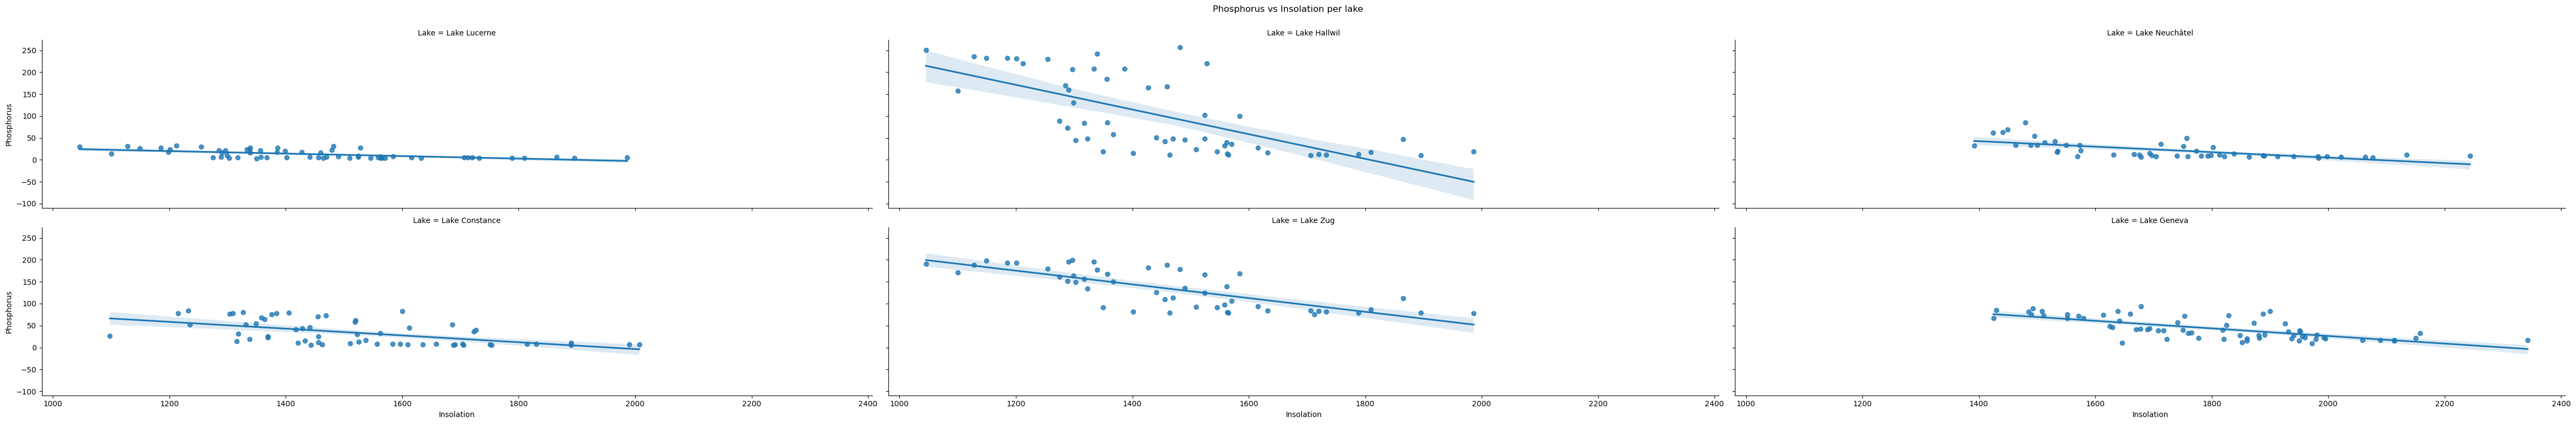

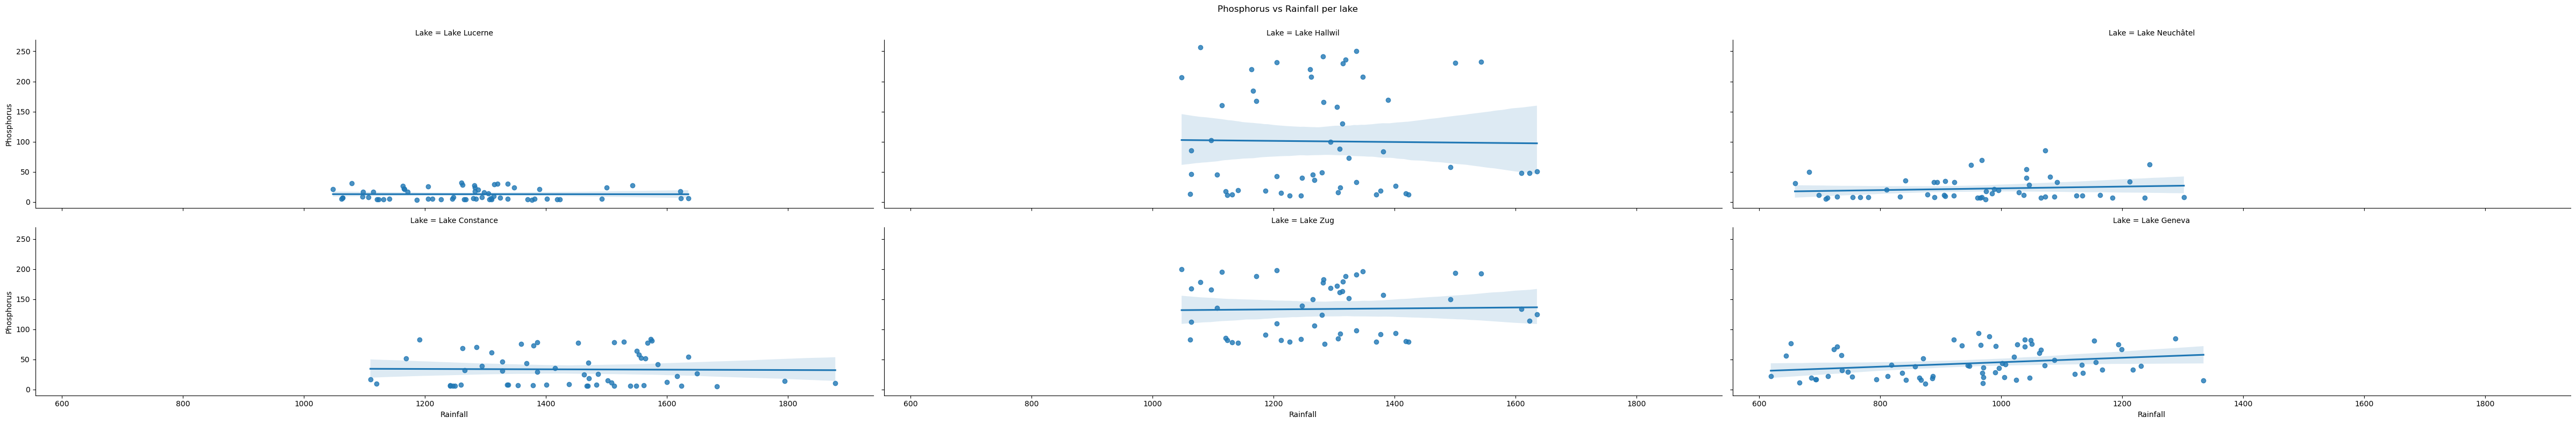

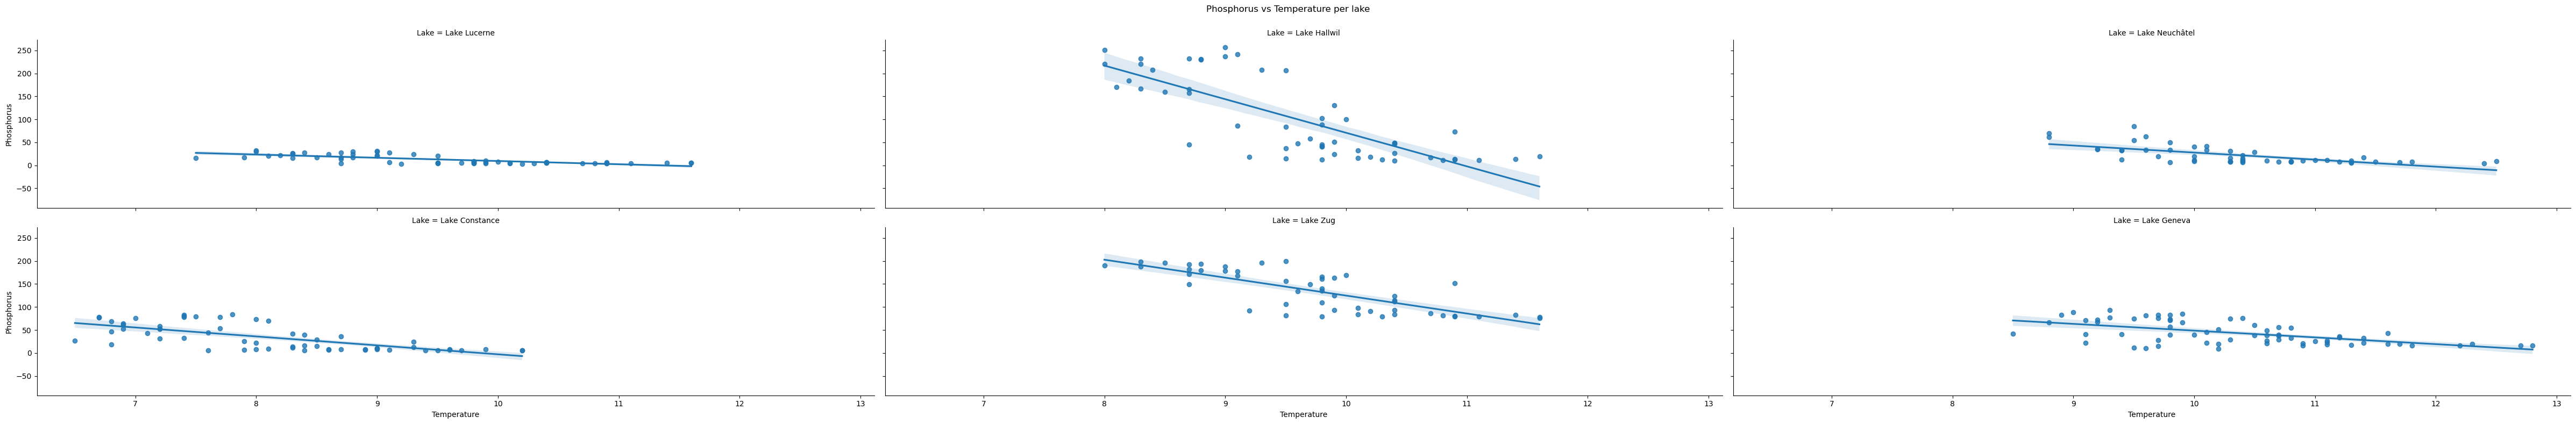

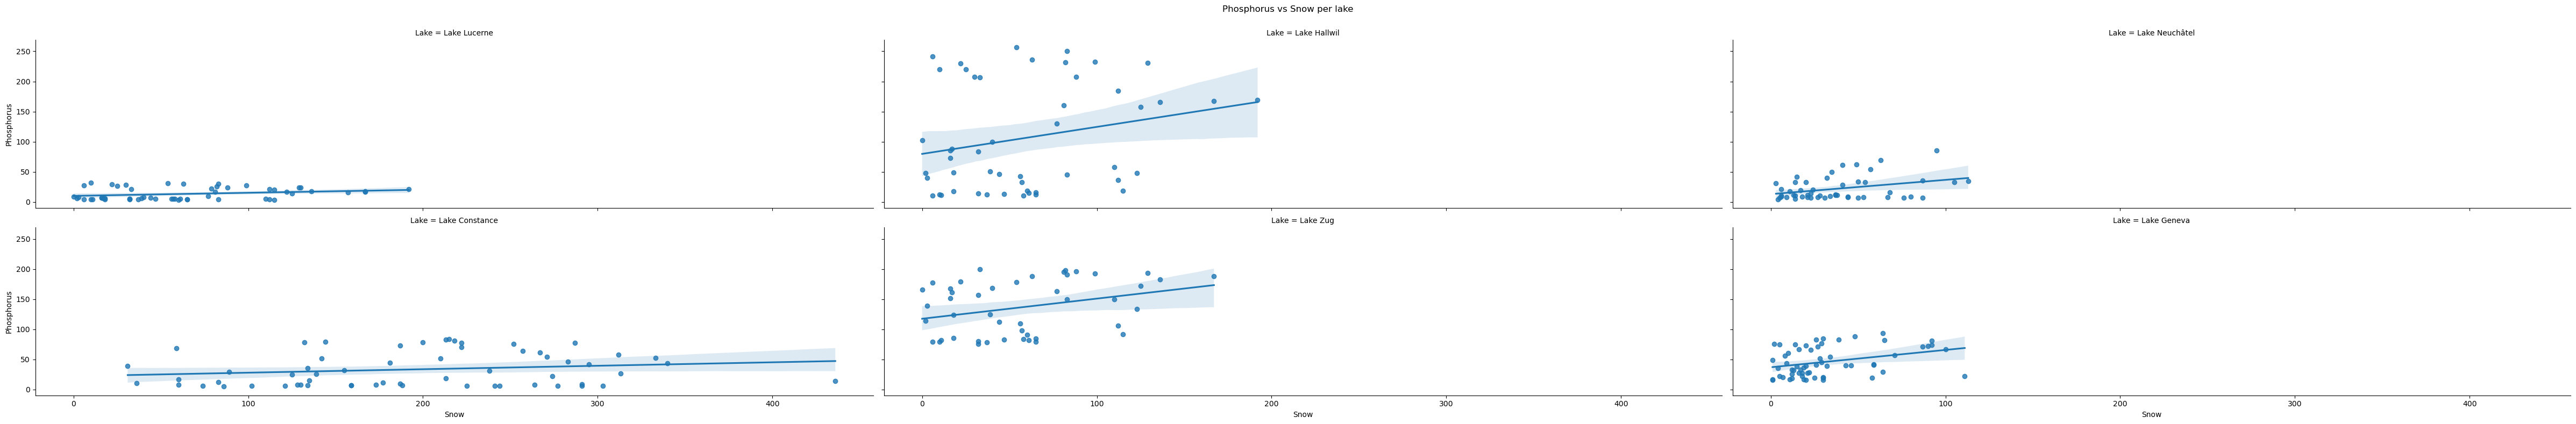

In [5]:
# Linear regression scatter plot
for var in ["Insolation", "Rainfall", "Temperature", "Snow"]:
    sns.lmplot(data=phospho_weather, x=var, y="Phosphorus", col="Lake", col_wrap=3, height=4, aspect=4)
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f"Phosphorus vs {var} per lake")
    plt.show()




Lake Lucerne - Linear regression:
                            OLS Regression Results                            
Dep. Variable:             Phosphorus   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     18.54
Date:                Fri, 09 May 2025   Prob (F-statistic):           1.84e-09
Time:                        16:11:23   Log-Likelihood:                -181.21
No. Observations:                  56   AIC:                             372.4
Df Residuals:                      51   BIC:                             382.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         1

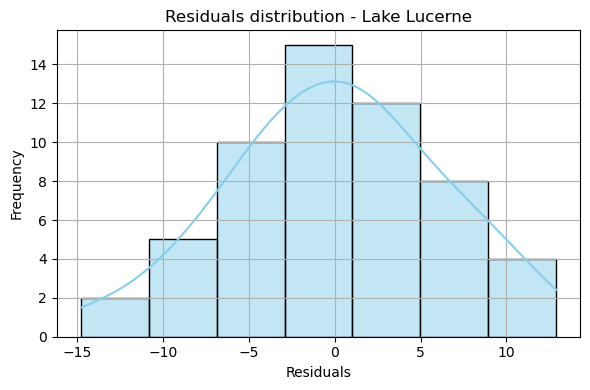

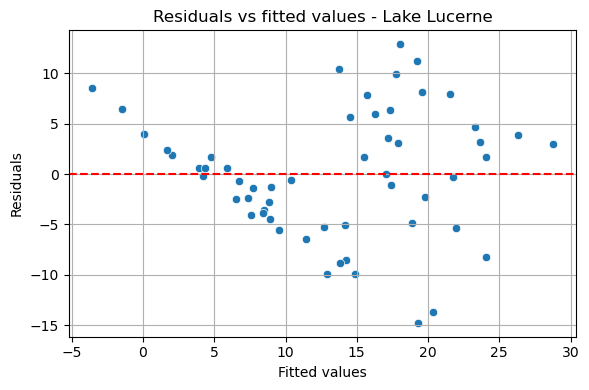


Lake Hallwil - Linear regression:
                            OLS Regression Results                            
Dep. Variable:             Phosphorus   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     23.72
Date:                Fri, 09 May 2025   Prob (F-statistic):           1.35e-10
Time:                        16:11:24   Log-Likelihood:                -265.74
No. Observations:                  50   AIC:                             541.5
Df Residuals:                      45   BIC:                             551.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        10

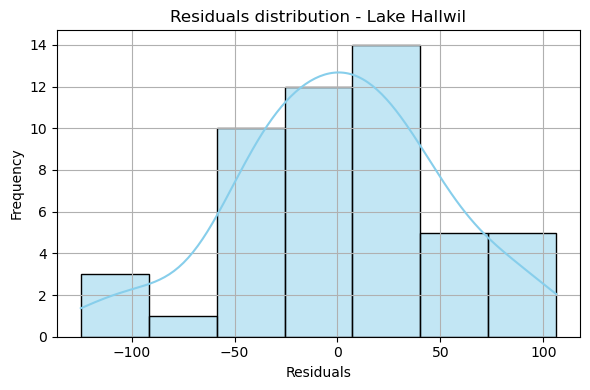

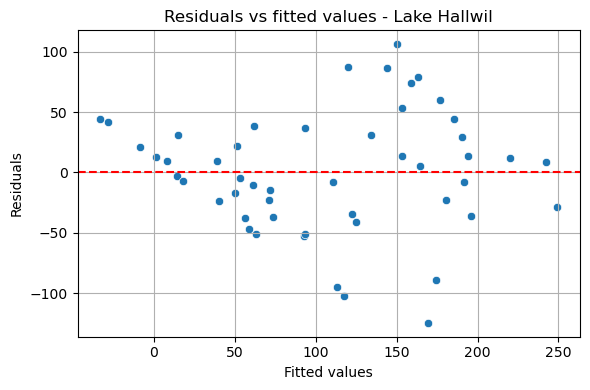


Lake Neuchâtel - Linear regression:
                            OLS Regression Results                            
Dep. Variable:             Phosphorus   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     11.74
Date:                Fri, 09 May 2025   Prob (F-statistic):           1.30e-06
Time:                        16:11:24   Log-Likelihood:                -200.60
No. Observations:                  50   AIC:                             411.2
Df Residuals:                      45   BIC:                             420.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        

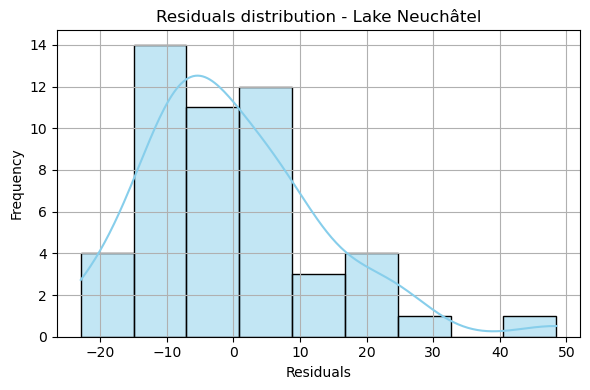

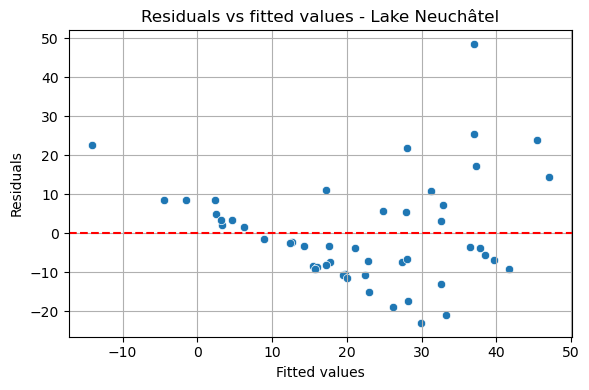


Lake Constance - Linear regression:
                            OLS Regression Results                            
Dep. Variable:             Phosphorus   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     15.35
Date:                Fri, 09 May 2025   Prob (F-statistic):           1.73e-08
Time:                        16:11:25   Log-Likelihood:                -261.28
No. Observations:                  60   AIC:                             532.6
Df Residuals:                      55   BIC:                             543.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        

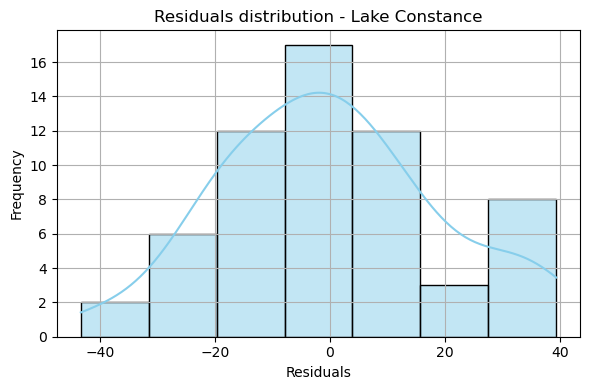

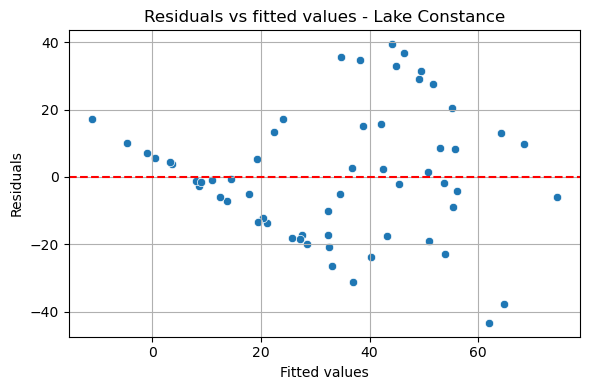


Lake Zug - Linear regression:
                            OLS Regression Results                            
Dep. Variable:             Phosphorus   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     23.34
Date:                Fri, 09 May 2025   Prob (F-statistic):           4.12e-10
Time:                        16:11:25   Log-Likelihood:                -211.97
No. Observations:                  46   AIC:                             433.9
Df Residuals:                      41   BIC:                             443.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         593.5

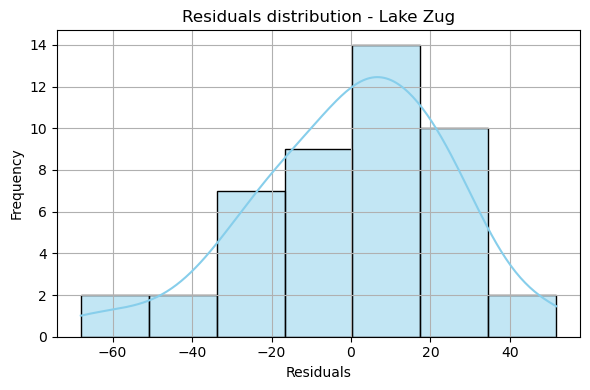

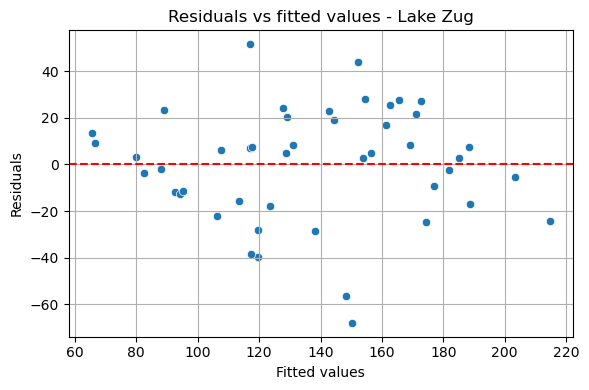


Lake Geneva - Linear regression:
                            OLS Regression Results                            
Dep. Variable:             Phosphorus   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     22.62
Date:                Fri, 09 May 2025   Prob (F-statistic):           3.70e-11
Time:                        16:11:25   Log-Likelihood:                -250.08
No. Observations:                  61   AIC:                             510.2
Df Residuals:                      56   BIC:                             520.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         27

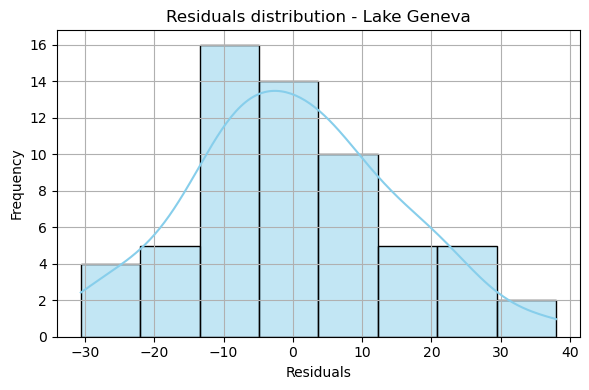

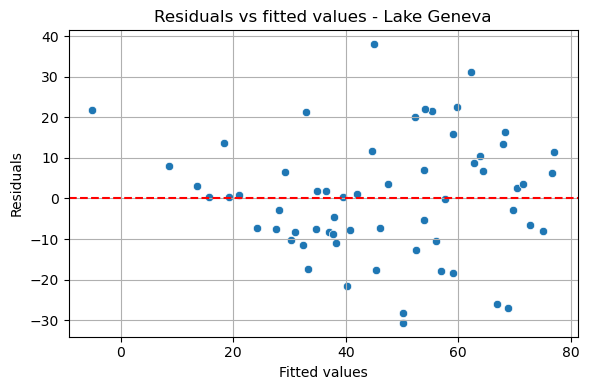

             lake     R²  Adj. R²  Significant predictors  Cond. no  \
0    Lake Lucerne  0.593    0.561        Temperature,Snow     31202   
1    Lake Hallwil  0.678    0.650  Insolation,Temperature     30092   
2  Lake Neuchâtel  0.511    0.467              Insolation     36437   
3  Lake Constance  0.527    0.493        Temperature,Snow     34458   
4        Lake Zug  0.695    0.665  Insolation,Temperature     32753   
5     Lake Geneva  0.618    0.590  Insolation,Temperature     35888   

  multicollinearity  
0               Yes  
1               Yes  
2               Yes  
3               Yes  
4               Yes  
5               Yes  


In [6]:
# Multiple linear regression
results_list = []

for lake in phospho_weather["Lake"].unique():
    subset = phospho_weather[phospho_weather["Lake"] == lake].dropna()
    x = subset[["Insolation", "Rainfall", "Temperature", "Snow"]]
    y = subset["Phosphorus"]
    x = sm.add_constant(x) # Add constant for intercept
    model = sm.OLS(y, x).fit()
    summary = model.summary2().tables[1] # Get coefficient and P-values
    significant = summary[summary["P>|t|"] < 0.05].index.tolist()
    if "const" in significant:
        significant.remove("const")
    print(f"\n{lake.title()} - Linear regression:")
    print(model.summary())
    residuals = model.resid
    fitted = model.fittedvalues

    results_list.append({
        "lake": lake,
        "R²": round(model.rsquared, 3),
        "Adj. R²": round(model.rsquared_adj, 3),
        "Significant predictors": ",".join(significant) if significant else "None",
        "Cond. no": int(np.linalg.cond(x)), # Rough multicollinearity indicator
        "multicollinearity": "Yes" if np.linalg.cond(x) > 3000 else "No"
        })

    # Residuals distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color="skyblue")
    plt.title(f"Residuals distribution - {lake}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Residuals vs fitted values
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, linestyle="--", color="red")
    plt.title(f"Residuals vs fitted values - {lake}")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

summary_df = pd.DataFrame(results_list)
print(summary_df)



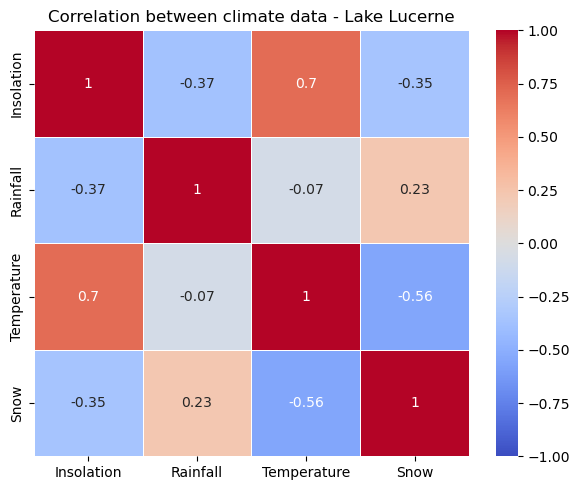

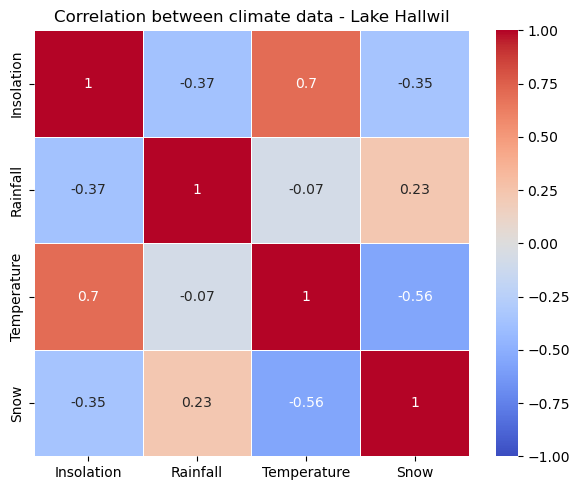

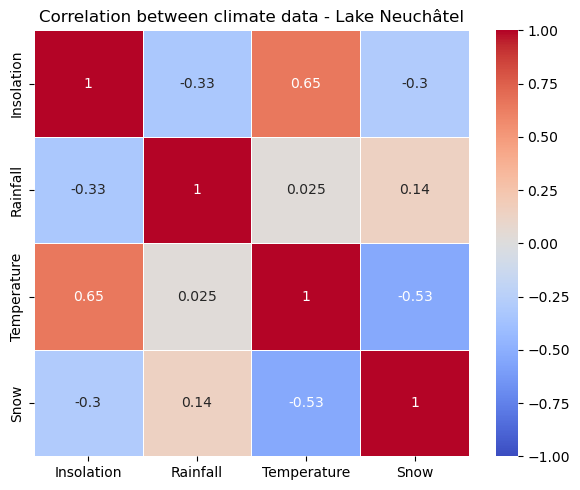

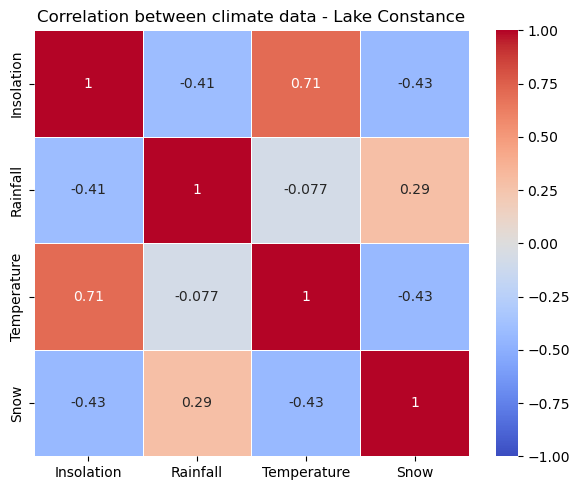

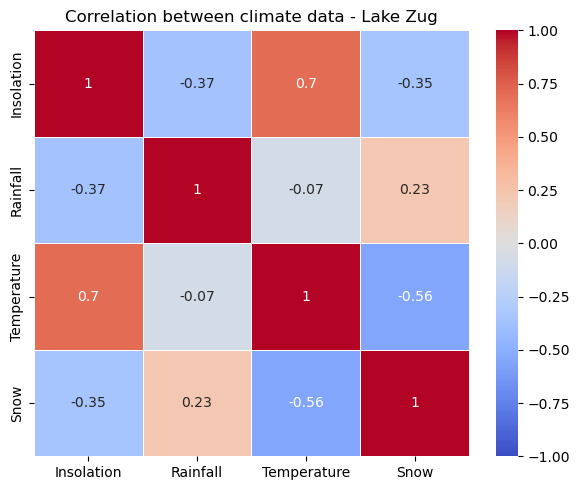

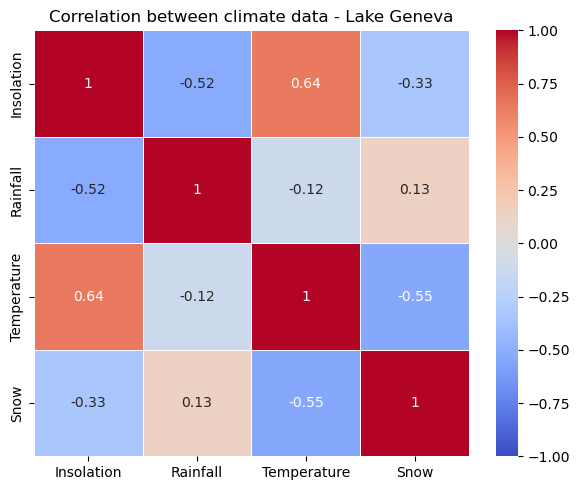

In [7]:
# Heatmap of the correlations within climate data for each lake
for lake in phospho_weather["Lake"].unique():
    subset = phospho_weather[phospho_weather["Lake"] == lake]
    corr = subset[["Phosphorus", "Insolation", "Rainfall", "Temperature", "Snow"]].corr()

    # Deleting phosphorus to avoid correlating to itself
    corr_trimmed = corr.drop("Phosphorus").drop("Phosphorus", axis=1)

    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_trimmed, annot=True, cmap="coolwarm", center=0, linewidths=0.5, vmin=-1, vmax=1)
    plt.title(f"Correlation between climate data - {lake}")
    plt.tight_layout()
    plt.show()



In [8]:
# Testing Ridge and Lasso regression models to see if it fits better to the data
models = {
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.1, max_iter=10000)
        }

ridge_lasso_results = []

for lake in phospho_weather["Lake"].unique():
    subset = phospho_weather[phospho_weather["Lake"] == lake].dropna()
    x = subset[["Insolation", "Rainfall", "Temperature", "Snow"]]
    y = subset["Phosphorus"]

    # Standardisation
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)

    # Split
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

    for model_name, model in models.items():
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ridge_lasso_results.append({
            "Lake": lake,
            "Model": model_name,
            "R² test": round(r2_score(y_test, y_pred), 3),
            "RMSE test": round(root_mean_squared_error(y_test, y_pred), 3),
            "Coefficients": dict(zip(x.columns, [round(c, 3) for c in model.coef_]))
            })

# Printing test results, and coefficients in a separate table (coefficients too long for first print)
ridge_lasso_df = pd.DataFrame(ridge_lasso_results)
print(f"Ridge and Lasso regression results \n")
for index, row in ridge_lasso_df.iterrows():
    print(f"Lake: {row['Lake']}, Model: {row['Model']}, R²: {row['R² test']}, RMSE: {row['RMSE test']}")
coeffs_df = pd.DataFrame([row["Coefficients"] for index, row in ridge_lasso_df.iterrows()])
coeffs_df.index = ridge_lasso_df["Lake"] + "-" + ridge_lasso_df["Model"]
print(f"\nClimate variable coefficients per lake")
print(coeffs_df)



Ridge and Lasso regression results 

Lake: Lake Lucerne, Model: Ridge, R²: 0.355, RMSE: 8.024
Lake: Lake Lucerne, Model: Lasso, R²: 0.345, RMSE: 8.08
Lake: Lake Hallwil, Model: Ridge, R²: 0.611, RMSE: 40.389
Lake: Lake Hallwil, Model: Lasso, R²: 0.591, RMSE: 41.461
Lake: Lake Neuchâtel, Model: Ridge, R²: -3.276, RMSE: 16.427
Lake: Lake Neuchâtel, Model: Lasso, R²: -3.301, RMSE: 16.475
Lake: Lake Constance, Model: Ridge, R²: 0.417, RMSE: 21.533
Lake: Lake Constance, Model: Lasso, R²: 0.42, RMSE: 21.492
Lake: Lake Zug, Model: Ridge, R²: 0.659, RMSE: 28.36
Lake: Lake Zug, Model: Lasso, R²: 0.654, RMSE: 28.537
Lake: Lake Geneva, Model: Ridge, R²: 0.224, RMSE: 19.754
Lake: Lake Geneva, Model: Lasso, R²: 0.215, RMSE: 19.88

Climate variable coefficients per lake
                      Insolation  Rainfall  Temperature    Snow
Lake Lucerne-Ridge        -1.454    -0.498       -7.207  -2.149
Lake Lucerne-Lasso        -1.112    -0.302       -7.522  -2.190
Lake Hallwil-Ridge       -25.927   -11.92

In [9]:
# Testing Random Forest Regression
rf_results = []
for lake in phospho_weather["Lake"].unique():
    subset = phospho_weather[phospho_weather["Lake"] == lake].dropna()
    x = subset[["Insolation", "Rainfall", "Temperature", "Snow"]]
    y = subset["Phosphorus"]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)

    rf_results.append({
        "Lake": lake,
        "Model": "Random Forest",
        "R² test": round(r2_score(y_test, y_pred), 3),
        "RMSE test": round(root_mean_squared_error(y_test, y_pred), 3)
        })

rf_df = pd.DataFrame(rf_results)
print("Random Forest Regression results")
print(rf_df)

Random Forest Regression results
             Lake          Model  R² test  RMSE test
0    Lake Lucerne  Random Forest    0.304      8.331
1    Lake Hallwil  Random Forest    0.353     52.104
2  Lake Neuchâtel  Random Forest   -1.881     13.485
3  Lake Constance  Random Forest    0.175     25.623
4        Lake Zug  Random Forest    0.628     29.581
5     Lake Geneva  Random Forest    0.360     17.948


## Results
### Exploratory analysis
Concerning the trend analysis (see file "trends_results.json") of the phosphorus, all trends are globally negative. However, when looking at the plot (fig-01.png), we can see that, for all lakes, the curves start with increasing values until the 70s - early 80s. From then on, the tendency is inverted, with decreasing values, giving the globally negative trend.

Concerning the trend analysis (see file "trends_results.json") of the weather data, it is a bit different. The trends are all positive for every locations for insolation time, rainfall and temperature. On the other hand, the fresh snow present negative trends for each locations. For a more detailed description, concerning insolation time (fig-02.png), all locations present a slow decrease in values until a minimum around 1980, before a rapid increase in values. The rainfall (fig-03.png) and fresh snow (fig-05.png) global trends looks generally quite flat, although variable values can vary significantly. Finally, the temperature plot (fig-04.png) show a clear increase in values over time, with what appears to be a positive exponential pattern.

### Correlations
The analysis of correlation between the phosphorus concentration and the climate data shows the same results for most locations. For every lakes except Lake Geneva, the climate parameter the most (negatively) correlated to the phosphorus concentration is the temperature (between -0.68 and -0.78), closely followed by the insolation time (between -0.55 and -0.75). The fresh snow is significantly less (positively) correlated (between 0.18 and 0.35), and then the rainfall is (negatively or positively) almost never correlated (between -0.02 and 0.12). As stated before, Lake Geneva is a bit different from the other lakes, since the climate parameter the most correlated to the phosphorus concentration is the insolation time (-0.70), followed by the temperature (-0.58). Another difference with the other lakes is the higher correlation values of the rainfall (0.26).

### Regression models
#### Single and multiple linear regression models
The first analysis consist in a simple linear regression model (fig-06.png to fig-09.png). For all climate parameters, the observed values for Lake Lucerne, Neuchâtel and Geneva are quite close to the line. However Lake Constance, Hallwil and Zug, the values are much more distant and scattered around the line. This is especially true for the rainfall and fresh snow.

Then, a multiple linear regression model was tested (fig-10.png to fig-21.png). The model present a R² comprised between 0.59 and 0.70, with Lake Neuchâtel and Constance having a lower value, respectively 0.51 and 0.53. This can be quite clearly observed on the residuals distribution plots of the lakes, where all lakes have a fairly normal distribution, except for Lake Neuchâtel and Constance, that have outliers. Appart for Lake Neuchâtel, for all the other lakes the common significant predicator of the phosphorus concentration is the temperature. Then, for Lake Neuchâtel, as well as three other lakes, the insolation is also considered as a significant predicator. Finally, for Lake Constance and Lucerne, the second significant predicator next to the temperature, is the fresh snow. According to the model, all lakes present multicolinearity in their parameters.

Since the model shows multicolinearity, the correlation between the climate parameters were calculated (fig-22.png to fig-27.png). For all lakes, the strongest correlation is between temperature and insolation time (between 0.64 and 0.71). Then comes the negative correlation between temperature and fresh snow (between -0.43 and -0.56). It is closely followed by the negative correlation between rainfall and insolation time (between -0.33 and -0.53). The fourth highest correlation, is the negative correlation between fresh snow and insolation time (between -0.30 and -0.43). Then rainfall is slighly less positively correlated to fresh snow (between 0.13 and 0.29). Finally, rainfall and temperature are almost not correlated at all (between -0.12 and 0.03).

#### Ridge and Lasso regression models
The Ridge and Lasso models present the highest R² values for Lake Zug (0.66 and 0.65), and Lake Hallwil (0.61 and 0.59). The other lakes have significantly lower values: 0.42 and 0.42 for Lake Constance, 0.36 and 0.35 for Lake Lucerne, and 0.22 and 0.22 for Lake Geneva. Finally, Lake Neuchâtel have particularly low R² values for these models: -3.28 and -3.30.

#### Random Forest Regression model
The last model to be tested is the Random Forest Regression. Appart for Lake Zug, that present a R² value of 0.63, the other lakes have values quite low compared to the previous models (between 0.18 and 0.36). Once again, just like for the Ridge and Lasso regression models, Lake Neuchâtel have a particularly low R² value (-1.88).

## Interpretation
In regard of the regression model, the one working the best is quite clearly the multiple linear regression model. However, for Lake Zug and Lake Hallwil, the Ridge and Lasso regression models have almost similar R² values. But it is also important to remember that the locations used for the climate data of these lakes are not exactly next to the lakes themselves, but further away. This could also be because Hallwil and Zug are the two lakes with the highest phosphorus concentration in comparison to the other lakes, and with a much more important decrease thab the others.

The multiple linear model being the best model seems to be consistent with the data. Indeed, according to the model the most significant predictors for the phosphorus concentration in the lakes are the temperature and the insolation. This make sense since the phosphorus concentration show an increase until ca. 1980 before decreasing until the present day (fig-01.png). On the other hand, the insolation time show a decrease until ca. 1980 before increasing (fig-02.png). And the temperature seems to be globally quite constant until ca. 1980 before also showing an increase in the values (fig-04.png). So it appears quite clearly that the phosphorus concentration follow the opposite tendancy of the one displyed by the insolation time and the temperature. This therefore meaning that in regard to the climate, a higher insolation time and higher temperature result in a lower phosphorus concentration in the lakes, and vice versa.

It seems also that there is a slight correlation between the phosphorus concentration in the lakes and the fresh snow, in the sense that both are decreasing over time (fig-01.png and fig-05.png). But this could be an artifact due to the fact that, since the phosphorus concentration tends to decrease when the temperature increases, that increase in temperature can also obviously lead to a decrease in fresh snow.

## Conclusion
In conclusion, according to the analysis and the available data, it seems that the phosphorus concentration in the swiss lakes tend to follow the insolation time and the temperature. This relationship is linear and negative. This results in a decrease in the phosphoruse concentration in the lakes when the insolation time and the temperature increase, and vice versa. There could be also a positive relationship between the phosphorus concentration in the lakes and the fresh snow, but it was not clearly proven, and thus it is probably an artifact due to the negative correlation between fresh snow and temperature.